# Q. Prepare a prediction model for profit of 50_startups data.

## 1. Importing Libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot
import statsmodels.formula.api as smf
import statsmodels.api as sm

## 2. Read the data :

In [2]:
startup_data = pd.read_csv('Startups.csv')
startup_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


## 3. Performing Exploratory Data Analysis (EDA) :

### (a) Rename the columns :

#### As some column name contain some spaces, so we have to remove it.

In [3]:
startup_data = startup_data.rename({'R&D Spend':'RD','Administration':'Admin','Marketing Spend':'Market'}, axis=1)
startup_data.head()

,RD,Admin,Market,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### (b) To find number of total rows and total columns :

In [4]:
startup_data.shape
print('Total number of rows:', startup_data.shape[0])
print('Total number of columns:', startup_data.shape[1])

Total number of rows: 50
Total number of columns: 5


### (C) To get all information about data set :

In [5]:
print(startup_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RD      50 non-null     float64
 1   Admin   50 non-null     float64
 2   Market  50 non-null     float64
 3   State   50 non-null     object 
 4   Profit  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB
None


#### From above output we can state that there is no NA values present in any data columns.

### (d) Copy the original data set : 

#### Now we have to copy this data set into new data set so that any changes made in new DataFrame don't get reflected in the original one.

In [6]:
startup_copy=startup_data.copy()

### (e) Removing rows where value is 0.00 : 

In [7]:
startup_copy = startup_copy[startup_copy['Market']!=0.00]
startup_copy = startup_copy[startup_copy['RD']!=0.00]

### (f) To find duplicates :

In [8]:
print('Duplicate row index number is:', startup_copy[startup_copy.duplicated()].shape[0])

Duplicate row index number is: 0


#### No duplicates present.

### (g) To find outlier :

#### 1. For R&D Spend column :

<AxesSubplot:>

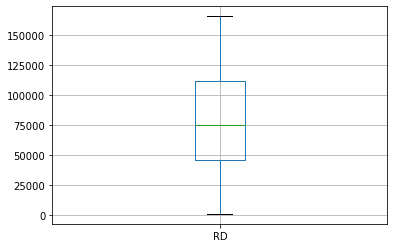

In [9]:
startup_copy.boxplot(column=['RD'])

#### There is no outliers present in R&D Spend column.

#### 2. For Administration Spend column :

<AxesSubplot:>

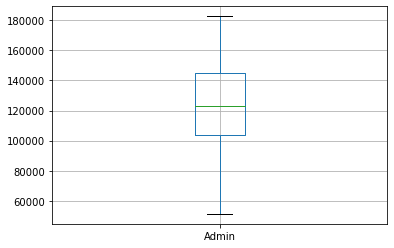

In [10]:
startup_copy.boxplot(column=['Admin'])

#### There is no outliers present in Administration Spend column.

#### 3. For Marketing Spend column :

<AxesSubplot:>

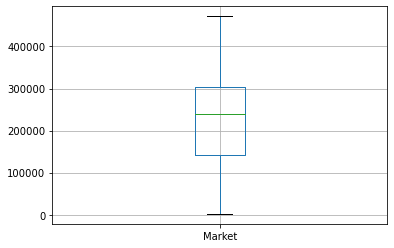

In [11]:
startup_copy.boxplot(column=['Market'])

#### There is no outliers present in Marketing Spend column.

#### 4. For State column :

<AxesSubplot:>

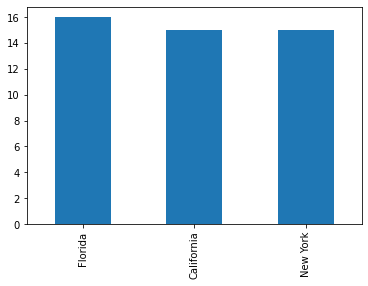

In [12]:
startup_copy['State'].value_counts().plot.bar()

#### From above bar plot we can see that data is approximately spered equally.

### (h) Scatter plot and Correlation analysis:

#### 1. To create default pairplot :

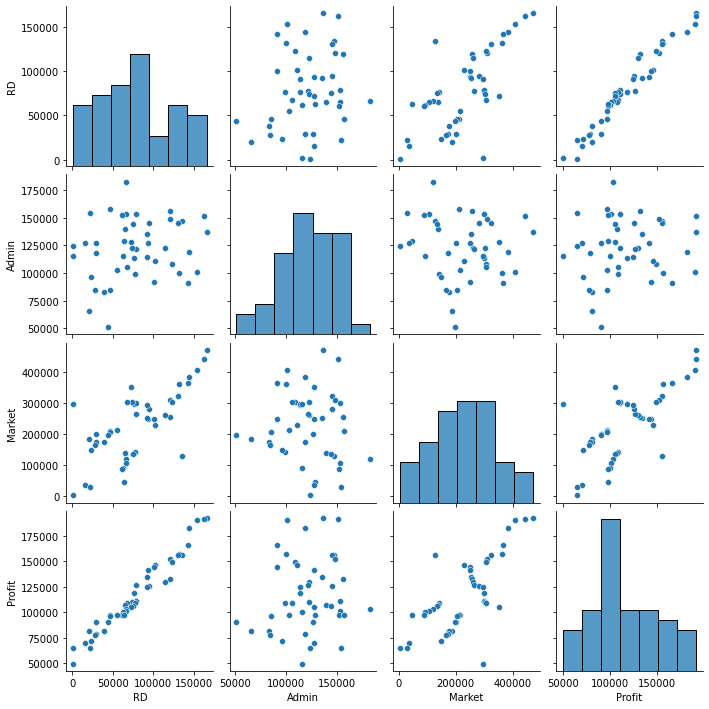

In [13]:
print(sns.pairplot(startup_copy))

#### 2. For Corrlation analysis :

In [14]:
print(startup_copy.corr())

              RD     Admin    Market    Profit
RD      1.000000  0.196068  0.708253  0.977703
Admin   0.196068  1.000000 -0.085831  0.135076
Market  0.708253 -0.085831  1.000000  0.732277
Profit  0.977703  0.135076  0.732277  1.000000


#### From above scatter plot and corrlation analysis we conclude that,
1. There is no relationship between independent variables.
2. Correlation between Profit and R&D data set is linear, positive directed and having strong correlation of 0.972. So,there is no need to perform any transformation on this column.
3. For Administration and Market columns scatter plot not linear and correlation between them is very low to the Profit column. So, we have to perform some transformation to improve the linearity between them.

## 4. Preparing a basic model for analysis :

In [15]:
basic_startup_model = smf.ols('Profit~RD+Admin+Market', data=startup_copy).fit()
print(basic_startup_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     343.4
Date:                Sun, 20 Jun 2021   Prob (F-statistic):           1.47e-29
Time:                        22:45:03   Log-Likelihood:                -472.80
No. Observations:                  46   AIC:                             953.6
Df Residuals:                      42   BIC:                             960.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.921e+04   5963.323      9.930      0.0

#### From above OLS Regression analysis we conclude that,
1. R^2 Value of a basic model is good but if we check p-values of Admin and Market it is high. So, from this we have to improve our p-values using transformation so that we can improve our R^2 value of the model.

## 4. Transformation :

### 1. Cook's Distance transformation on overall model :

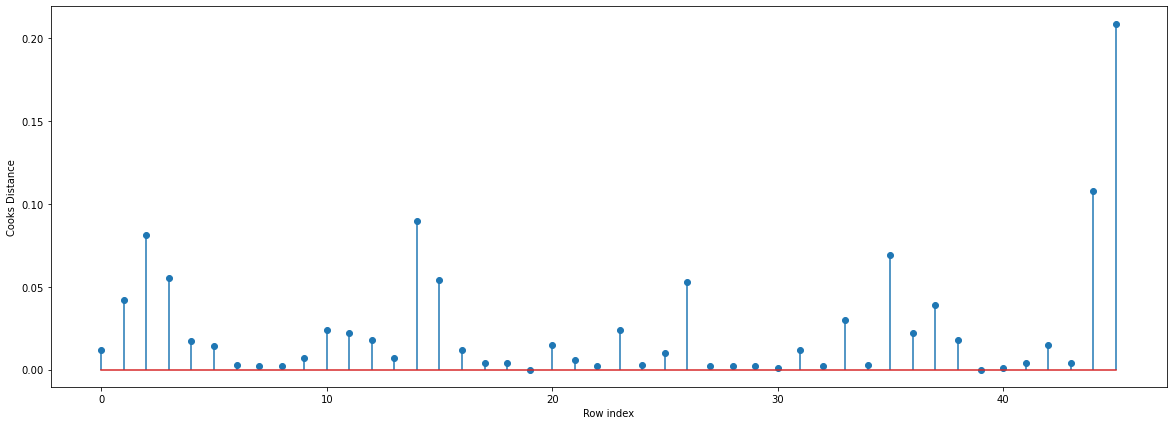

In [16]:
startup_copy['State']=startup_copy['State'].astype('category')
basic_model_influence = basic_startup_model.get_influence()
(c, _) = basic_model_influence.cooks_distance
fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(startup_copy)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

#### From above Cook's distance plot we can see that index row number 44 and 45 are high influence point. Hence, we cam remove that records. 

In [17]:
startup_improve = startup_copy.drop(startup_copy.index[[45,44]],axis=0).reset_index()
startup_improve = startup_improve.drop(['index'],axis=1)

In [18]:
startup_admin = smf.ols('Profit~Admin', data=startup_improve).fit()
print(startup_admin.rsquared,startup_admin.aic)

0.018854162985237788 1045.9851738942925


In [19]:
startup_market = smf.ols('Profit~Market', data=startup_improve).fit()
print(startup_market.rsquared,startup_market.aic)

0.6097904256741474 1005.4155395036087


#### Compairing above R^2 Value and AIC Value model 'startup_market' has high value hence we can include this value.

### 2. Cook's Distance transformation on 'startup_admin' model :

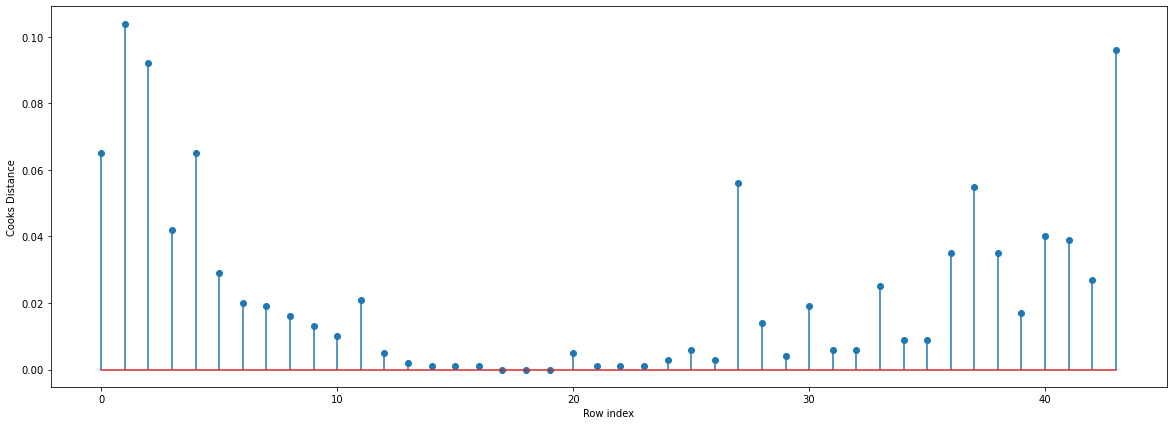

In [20]:
model_influence_admin = startup_admin.get_influence()
(c_admin,_) = model_influence_admin.cooks_distance
fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(startup_improve)), np.round(c_admin, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

In [21]:
startup_admin_improve = startup_improve.drop(startup_improve.index[[1,2,43,0,4,27,37,3]],axis=0)
startup_admin_improve = startup_admin_improve.reset_index()
startup_admin_improve = startup_admin_improve.drop(['index'],axis=1)
startup_admin_improve_model = smf.ols('Profit~Admin', data=startup_admin_improve).fit()
print(startup_admin_improve_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.580
Date:                Sun, 20 Jun 2021   Prob (F-statistic):              0.117
Time:                        22:45:04   Log-Likelihood:                -414.64
No. Observations:                  36   AIC:                             833.3
Df Residuals:                      34   BIC:                             836.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.087e+04   2.09e+04      3.867      0.0